In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import importlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from memoization import cached
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN , OPTICS
from sklearn.manifold import TSNE 
from sklearn import preprocessing
from utils import *
import utils


## Download Price yf_download

In [3]:
@cached
def yf_download(symbol, start, end):
    df = yf.download(symbol, start, end)[["Adj Close"]]
    return df
# AAPL = yf_download("AAPL", "2016-01-01", "2018-01-01")
# GOOG = yf_download("GOOG", "2016-01-01", "2018-01-01")

# Put ETF_5years.csv in your directory
etfs = pd.read_csv("ETF.csv").Symbol.tolist()
if os.path.exists("ETF_5years.csv"):
    Price = pd.read_csv("ETF_5years.csv", index_col=0)
else:
    Price = yf_download(etfs[0], "2017-01-01", "2022-01-01")
    Price.columns = [etfs[0]]
    for etf in etfs[1:]:
        Price_etf = yf_download(etf, "2017-01-01", "2022-01-01")
        Price_etf.columns = [etf]
        if len(Price_etf) < 1200:
            continue
        Price = Price.merge(Price_etf, left_index=True, right_index=True, how="left")
    Price.to_csv("ETF_5years.csv")

## OPTICS cluster

## cluster transition in different periods

In [4]:
TRAIN_START = "2017-01-01"
TRAIN_END = "2020-01-01"
df_ret_train = Price.pct_change()[1:].loc[:TRAIN_END].copy()
# OPTICS_fit(df_returns)
# DBSCAN_fit(df_returns, 0.1, 4)

# we normalize df_ret_train by each day and then cluster use OPTICS clustering
labels = OPTICS_fit(normalize(df_ret_train))
print(labels)
n_clusters_ = len(set(labels)) - 1
print("Clusters discovered:", n_clusters_)

clustered_series_all = pd.Series(index=df_ret_train.columns, data=labels)
# If it is -1, it means it is a seperate cluster with very few elements
clustered_series = clustered_series_all[clustered_series_all != -1]
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts > 1)]
print("Pairs in group to evaluate:", (ticker_count_reduced * (ticker_count_reduced - 1)).sum() // 2)

[ 0  0  0  0 -1  4  4  1  6 -1  6  2 -1  3  2  3 -1 -1  3  1  4 -1  4 -1
 -1  3 -1 -1 -1  6  0  1  5  5  4 -1  2 -1 -1 -1  0 -1 -1  4 -1  0 -1 -1
 -1  4 -1  3  0 -1  1 -1  6 -1 -1  5  0 -1  4  5 -1 -1 -1  5 -1  3 -1  6
 -1  4 -1  6 -1 -1 -1 -1 -1  3 -1  2  3 -1 -1  3 -1 -1 -1  5  5 -1  1  5
  3 -1]
Clusters discovered: 7
Pairs in group to evaluate: 176


## Visualize stock clusters using X_tsne

X_tsne Shape (98, 2)


<Figure size 1080x720 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'T-SNE of all Stocks with OPTICS Clusters Noted')

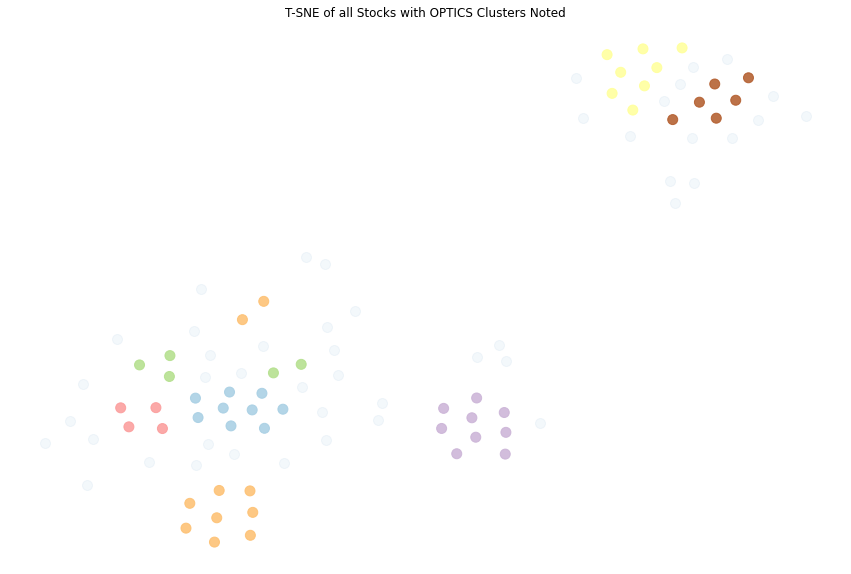

In [6]:
X_tsne = TSNE(learning_rate=1000, perplexity=25).fit_transform(normalize(df_ret_train).T)
print("X_tsne Shape", X_tsne.shape)
plt.figure(1, facecolor='white', figsize=(15,10))
plt.clf()
plt.axis('off')
# clustered
plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)
# unclustered in the background
plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)
plt.title('T-SNE of all Stocks with OPTICS Clusters Noted')
plt.show()

add some weight to cluster; trading volume
sum of the volume is highest display the name of stock which has the highest value


### Cluster Member Counts

<Figure size 864x504 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Cluster Member Counts')

Text(0.5, 0, 'Stocks in Cluster')

Text(0, 0.5, 'Cluster Number')

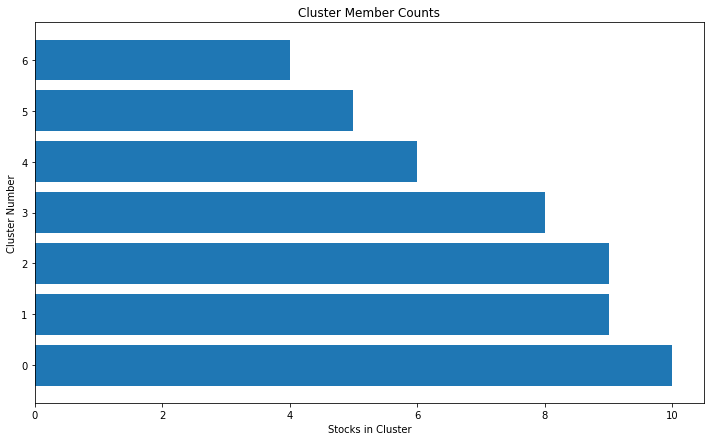

In [7]:
plt.figure(figsize=(12,7))
plt.barh(
range(len(clustered_series.value_counts())), # cluster labels, y axis 
      clustered_series.value_counts()
         )
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

## choose more stocks

### Plot the stock price within same cluster

<AxesSubplot:title={'center':'Stock Time Series for Cluster 2'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 1'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 6'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 5'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 4'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 0'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 3'}, xlabel='Date'>

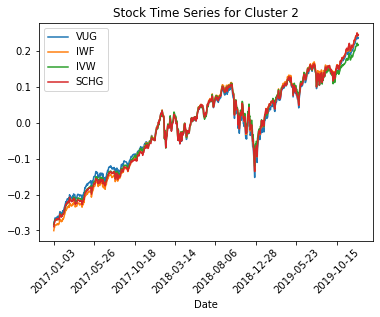

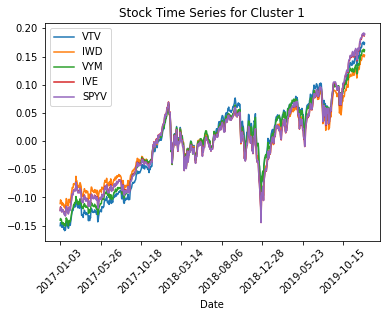

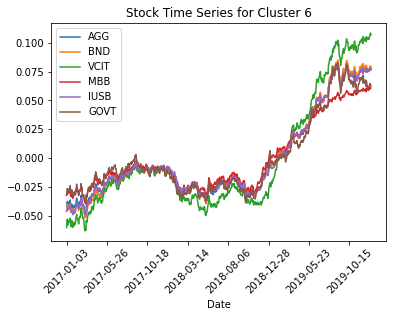

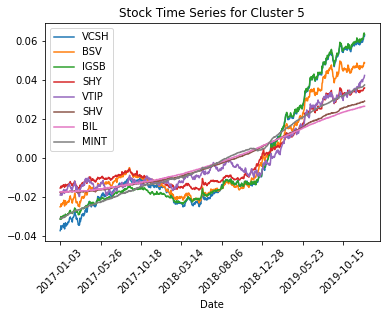

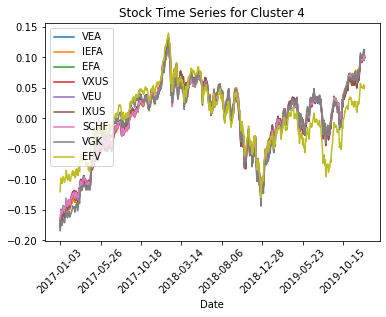

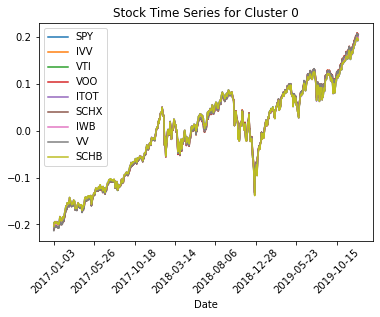

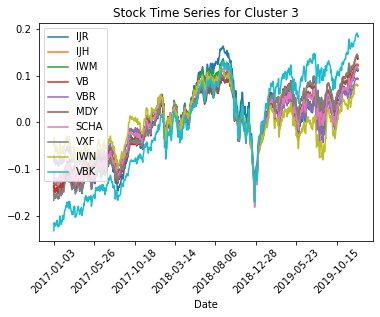

In [6]:
# get the number of stocks in each cluster 
counts = clustered_series.value_counts()
# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]
# plot a handful of the smallest clusters
for clust in cluster_vis_list: 
    tickers = list(clustered_series[clustered_series==clust].index) 
    means = np.log(Price.loc[:TRAIN_END, tickers].mean())
    this_data = np.log(Price.loc[:TRAIN_END, tickers]).sub(means) 
    this_data.plot(title='Stock Time Series for Cluster %d' % clust, rot=45)
    
plt.show()

## Calculate Cointegration
### Get p value of ADF test
if p is small, means the residual is stationary

In [8]:
significance = 0.05
start_day = TRAIN_START
end_day = TRAIN_END
E_selection = False
Opt_pairs = PairSelection(Price, ticker_count_reduced, clustered_series, significance, start_day, end_day, E_selection)

print("Number of clusters: ",len(ticker_count_reduced))
print("Number of cointegrated pairs: ",len(Opt_pairs))
print("Pairs with lowest p-value among all the clusters:")
Opt_pairs


Number of clusters:  7
Number of cointegrated pairs:  4
Pairs with lowest p-value among all the clusters:


[['VB', 'VXF'], ['SCHX', 'VV'], ['AGG', 'IUSB'], ['IVV', 'SCHX']]

## select largest volatility from pairs

Text(0.5, 0, 'O UN Equity')

Text(0, 0.5, 'VTR UN Equity')

Text(0.5, 0, 'AVA UN Equity')

Text(0, 0.5, 'UTL UN Equity')

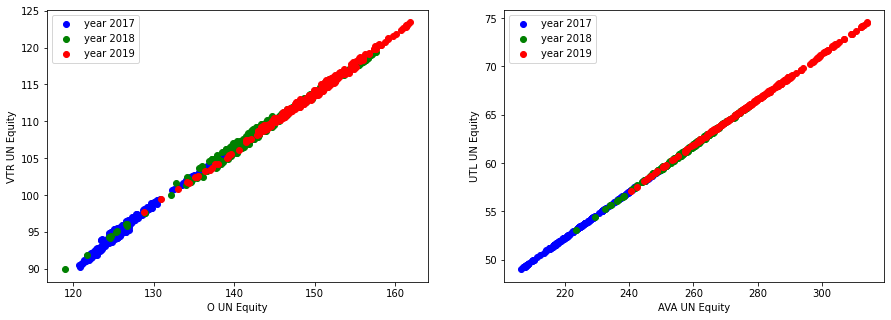

In [8]:
stock_VB = Price.loc[TRAIN_START:TRAIN_END, Opt_pairs[0][0]]
stock_VXF = Price.loc[TRAIN_START:TRAIN_END, Opt_pairs[0][1]]
stock_IVV = Price.loc[TRAIN_START:TRAIN_END, Opt_pairs[-1][0]]
stock_SCHX = Price.loc[TRAIN_START:TRAIN_END, Opt_pairs[-1][1]]
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(15,5))
ax1.set_xlabel("O UN Equity")
ax1.set_ylabel("VTR UN Equity")
ax1.scatter(stock_VB[0:252],stock_VXF[0:252], color='b',
            label = 'year 2017')
ax1.scatter(stock_VB[252:504],stock_VXF[252:504], color='g',
            label = 'year 2018')
ax1.scatter(stock_VB[504:756],stock_VXF[504:756], color='r',
            label = 'year 2019')
ax1.legend()
ax2.set_xlabel("AVA UN Equity")
ax2.set_ylabel("UTL UN Equity")
ax2.scatter(stock_IVV[0:252],stock_SCHX[0:252], color='b',
            label = 'year 2017')
ax2.scatter(stock_IVV[252:504],stock_SCHX[252:504], color='g',
            label = 'year 2018')
ax2.scatter(stock_IVV[504:756],stock_SCHX[504:756], color='r',
            label = 'year 2019')

ax2.legend()
plt.show()

## Bolling Band strategy


## ARIMA predict return

In [9]:
symbol1, symbol2 = Opt_pairs[0]
df = Price[[symbol1, symbol2]]
df["Hedged"] = df.iloc[:,0] * get_hedgeRatio(df)
df["dif"] = df["Hedged"] - df.iloc[:,1]

In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df["dif"].diff(), order=(5, 1, 0))
model = model.fit()
model.summary()
model.forecast()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    dif   No. Observations:                 1259
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1003.810
Date:                Fri, 25 Feb 2022   AIC                           2019.620
Time:                        15:41:16   BIC                           2050.444
Sample:                             0   HQIC                          2031.204
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8544      0.020    -43.746      0.000      -0.893      -0.816
ar.L2         -0.7069      0.023    -31.074      0.000      -0.752      -0.662
ar.L3         -0.5632      0.024    -23.100      0.000      -0.611      -0.515
ar.L4         -0.4235      0.023    -18.259      0.000      -0.469      -0.378
ar.L5         -0.1707      0.018     -9.609      0.000      -0.206      -0.136
sigma2         0.2853      0.006     43.951      0.000       0.273       0.298
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):              1185.08
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):              10.29   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1259    0.4243
dtype: float64

## Walking ARIMA

In [11]:
X = df["dif"]
size = 252 * 3
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
# for t in range(len(test)):
for t in range(5):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts


predicted=29.661153, expected=29.489630
predicted=29.508797, expected=29.450461
predicted=29.450667, expected=29.403166
predicted=29.399288, expected=29.413041
predicted=29.410231, expected=29.226714


## ARIMA Strategy Test
Returns are quite high!

In [84]:
# money = 0
# long = False
# short = False
# hists = [] # store each transaction information
# lookback = 3 * 252

# X = df["dif"]
# size = 252 * 3
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# t = 0

# df_hist = df["dif"][:lookback]
# # mu = df_hist.mean()
# sigma = df_hist.std()
# # u1, u2, d1, d2 = 0, 2, 0, 2
# long_threshold = df_hist.quantile(0.2)
# long_stop_threshold = df_hist.quantile(0.5)
# short_threshold = df_hist.quantile(0.8)
# short_stop_threshold = df_hist.quantile(0.5)

# for index, price in df["dif"][lookback:][:].iteritems():
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]

#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
#     t += 1
#     sigma = np.std(history)
#     if price < yhat - 0.5 * sigma and not long:
#         long = True
#         money -= price 
#     if price > yhat + 0.5 * sigma and long:
#         long = False 
#         money += price 
#     if price > yhat + 0.5 * sigma and not short:  
#         short = True 
#         money += price 
#     if price < yhat - 0.5 * sigma and short:
#         short = False 
#         money -= price 
#     hists.append([index, price, long, short, money])

# # sell or buy back on the last day
# if short:
#     money -= price 
# if long:
#     money += price 
# money

In [86]:
class BaseStrategy:
    def __init__(self):
        self.prices_hist = []
        self.long_threshold = 0
        self.long_stop_threshold = 0
        self.short_threshold = 0
        self.short_stop_threshold = 0
        self.model = None 
    
    def fit(self, prices_hist: pd.Series):
        pass 

    def predict(self):
        return (self.long_threshold, 
                self.long_stop_threshold, 
                self.short_threshold, 
                self.short_stop_threshold,)


class StrategyArima(BaseStrategy):
    def __init__(self, params=[-0.5, 0, 0.5, 0], pdq=(5, 1, 0)):
        super().__init__()
        self.params = params
        self.model = None
        assert len(pdq) == 3, "wrong length of pdq"
        self.p, self.d, self.q = pdq
    
    def fit(self, prices_hist, pdq=(5,1,0)):
        model = ARIMA(prices_hist, order=(self.p,self.d,self.q)).fit()
        output = model.forecast()
        yhat = output.iloc[0]
        print("Arima predicted", output.iloc[0])
        sigma = prices_hist.std()
        l, ls, s, ss = self.params
        self.long_threshold = yhat + l * sigma 
        self.long_stop_threshold = yhat + ls * sigma 
        self.short_threshold = yhat + s * sigma 
        self.short_stop_threshold = yhat + ss * sigma 


class StrategyQuantile(BaseStrategy):
    def __init__(self, params=[0.2, 0.5, 0.8, 0.5]):
        super().__init__()
        self.params = params
    
    def fit(self, prices_hist):
        l, ls, s, ss = self.params
        self.long_threshold = prices_hist.quantile(l)
        self.long_stop_threshold = prices_hist.quantile(ls)
        self.short_threshold = prices_hist.quantile(s)
        self.short_stop_threshold = prices_hist.quantile(ss)


class StrategySigma(BaseStrategy):
    def __init__(self, params=[-1, 0, 1, 0]):
        super().__init__()
        self.params = params
    
    def fit(self, prices_hist):
        sigma = prices_hist.std()
        mu = prices_hist.mean()
        l, ls, s, ss = self.params
        self.long_threshold = mu + l * sigma
        self.long_stop_threshold = mu + ls * sigma
        self.short_threshold = mu + s * sigma
        self.short_stop_threshold = mu + ss * sigma


class StrategyRF(BaseStrategy):
    def __init__(self, params=[-0.5, 0, 0.5, 0]):
        super().__init__()
        self.params = params
        self.clf = None

    def fit(self, prices_hist):
        if not self.clf or len(prices_hist) % 10 == 0:
            difs = pd.DataFrame(prices_hist)
            difs.columns = ["dif"]
            for i in range(1,10):
                difs[f"dif{i}"] = difs["dif"].shift(i)
            difs = difs.dropna()
            clf = RandomForestRegressor()
            X_train, y_train = difs.iloc[:-1, 1:], difs.iloc[:-1, 0]
            X_test, y_test = difs.iloc[-1, 1:], difs.iloc[-1:, 0]
            clf.fit(X_train, y_train)
            self.clf = clf 
        X_test = prices_hist[-9:][::-1]
        yhat = self.clf.predict([X_test])[0]
        print("Random Forest predicted", yhat)
        sigma = prices_hist.std()
        l, ls, s, ss = self.params
        self.long_threshold = yhat + l * sigma 
        self.long_stop_threshold = yhat + ls * sigma 
        self.short_threshold = yhat + s * sigma 
        self.short_stop_threshold = yhat + ss * sigma 
        


def backTester(prices : pd.Series, strategy: BaseStrategy, lookback=252*3):
    
    prices_train, prices_test = prices[:lookback], prices[lookback:]

    money = 0; long = False; short = False
    hists = [] # store each transaction information
    history = prices_train.tolist()
    for index, price in prices_test.iteritems():
        strategy.fit(pd.Series(history)) # fit the strategy, pass series
        long_threshold, long_stop_threshold, \
            short_threshold, short_stop_threshold = strategy.predict()
        history.append(price) # update history
        if price < long_threshold and not long:
            long = True
            money -= price 
        if price > long_stop_threshold and long:
            long = False 
            money += price 
        if price > short_threshold and not short:  
            short = True 
            money += price 
        if price < short_stop_threshold and short:
            short = False 
            money -= price 
        hists.append([index, price, long, short, money])

    # sell or buy back on the last day
    if short: money -= price 
    if long: money += price 

    print("Final money", round(money, 2))
    df_hist = pd.DataFrame(hists, columns=["date", "price_dif", "long", "short", "money"])
    df_hist["PnL"] = df_hist["money"] + (df_hist["long"].astype(int) - df_hist["short"].astype(int)) * df_hist["price_dif"]
    
    return money, df_hist

In [89]:
_, df_hist_quantile = backTester(df["dif"], StrategyQuantile([0.2, 0.5, 0.8, 0.5]))
_, df_hist_sigma = backTester(df["dif"], StrategySigma([-2, 0, 0, 2]))
_, df_hist_arima = backTester(df["dif"], StrategyArima([-0.5, 0, 0.5, 0]))
_, df_hist_rf = backTester(df["dif"], StrategyRF([-0.5, 0, 0.5 ,0]))

Final money 9.74
Final money 4.26
Arima predicted 29.661153429282827
Arima predicted 29.508796667730074
Arima predicted 29.450666819104672
Arima predicted 29.39928837873321
Arima predicted 29.410231284570386
Arima predicted 29.227045616093648
Arima predicted 29.35878809351032
Arima predicted 29.455620893441168
Arima predicted 29.558714028846023
Arima predicted 29.944212978735322
Arima predicted 29.893041206442497
Arima predicted 29.581151097672393
Arima predicted 29.366751963325196
Arima predicted 29.30818937570481
Arima predicted 28.827705563334636
Arima predicted 28.426487994735872
Arima predicted 28.764866062412953
Arima predicted 28.677323556289
Arima predicted 28.38983628852567
Arima predicted 27.605622345062166
Arima predicted 27.270932958037317
Arima predicted 27.46048399487698
Arima predicted 28.601467039712848
Arima predicted 28.35072439546938
Arima predicted 27.960498659661287
Arima predicted 27.982945429476047
Arima predicted 28.181607163359168
Arima predicted 28.45620421361

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

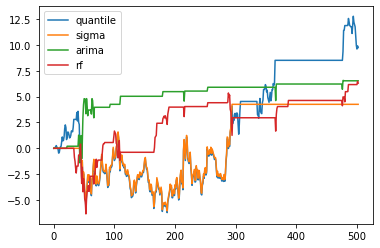

In [96]:
df_hist_quantile["PnL"].plot()
df_hist_sigma["PnL"].plot()
df_hist_arima["PnL"].plot()
df_hist_rf["PnL"].plot()
plt.legend(["quantile", "sigma", "arima", "rf"])

In [98]:
df_hist_arima

,date,price_dif,long,short,money,PnL
0,2020-01-06,29.489630,False,False,0.000000,0.000000
1,2020-01-07,29.450461,False,False,0.000000,0.000000
2,2020-01-08,29.403166,False,False,0.000000,0.000000
3,2020-01-09,29.413041,False,False,0.000000,0.000000
4,2020-01-10,29.226714,False,False,0.000000,0.000000
...,...,...,...,...,...,...
498,2021-12-27,30.367028,False,False,6.533032,6.533032
499,2021-12-28,31.238104,False,False,6.533032,6.533032
500,2021-12-29,31.584801,False,False,6.533032,6.533032
501,2021-12-30,31.280498,False,False,6.533032,6.533032


In [85]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, predictions))
rmse

0.7188750248821454